# decision tree classifier

In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm #color maps
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from itertools import chain, combinations

## load features

In [2]:
features = pd.read_csv('../jv-features.csv')
cc_features = pd.read_csv('../cc-features.csv')
features = features.merge(cc_features[['date','PctPNC','PctWP']], on='date')

features.sample(5)

,date,Weekday,OtherPuzAns,BlockDensity,AvgHintLength,AvgAnswerLength,NumHints,NumOneWordHints,PctOneWdHints,PctPerplex,WeekdayNum,NumRepeatedAnswers,CumTotalAnswers,NumRepeatedAnswers_Norm,PctPNC,PctWP
9494,2020-04-12,Sunday,62.235714,16.326531,22.114286,5.271429,140,14,10.000000,3.571429,6,133,113871,0.000008,28.571429,2.857143
4661,2007-01-05,Friday,40.985714,11.555556,18.614286,5.685714,70,10,14.285714,7.142857,4,58,75455,0.000011,30.000000,7.142857
7919,2015-12-17,Thursday,59.578947,16.000000,18.894737,5.289474,76,14,18.421053,6.578947,3,69,102374,0.000009,23.684211,7.894737
4387,2006-03-15,Wednesday,69.705128,16.000000,16.217949,4.846154,78,9,11.538462,3.846154,2,72,72921,0.000013,23.076923,7.692308
1208,1997-05-17,Saturday,36.750000,12.888889,16.102941,5.764706,68,19,27.941176,2.941176,5,49,35239,0.000020,16.176471,2.941176


In [3]:
class_labels = features.groupby(['WeekdayNum','Weekday']).size().reset_index()['Weekday'].tolist()

In [4]:
def powerset(iterable):
    combos = []
    for i in range(1,len(iterable)+1):
        for c in combinations(iterable, i):
            combos.append(list(c))
    return combos

## CV for depth

In [5]:
X = features[['BlockDensity', 'OtherPuzAns', 'AvgAnswerLength', 'PctOneWdHints', 'PctWP']].to_numpy()
y = features[['WeekdayNum']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 617, 
                                                    shuffle=True,
                                                    stratify=y)

kfold = StratifiedKFold(n_splits=5,shuffle = True,random_state=440)
n = 20

accs = np.zeros((5,n))
precs = np.zeros((5,n))
recs = np.zeros((5,n))

for j in range(1,n+1):
    tree_clf = DecisionTreeClassifier(max_depth=j, random_state=440)
    if j % 5 == 0:
            print(f"testing depth = {j} (to {n})")
    i=0
    for train_index, test_index in kfold.split(X_train,y_train):
        X_train_train, X_train_test = X_train[train_index], X_train[test_index]
        y_train_train, y_train_test = y_train[train_index], y_train[test_index]
        
        tree_clone = clone(tree_clf)
        tree_clone.fit(X_train_train, y_train_train)
        
        y_pred = tree_clone.predict(X_train_test)
        accs[i,j-1] = accuracy_score(y_train_test,y_pred)
        precs[i,j-1] = precision_score(y_train_test,y_pred,average='weighted',zero_division=0)
        recs[i,j-1] = recall_score(y_train_test,y_pred,average='weighted',zero_division=0)
        i = i + 1

testing depth = 5 (to 20)
testing depth = 10 (to 20)
testing depth = 15 (to 20)
testing depth = 20 (to 20)


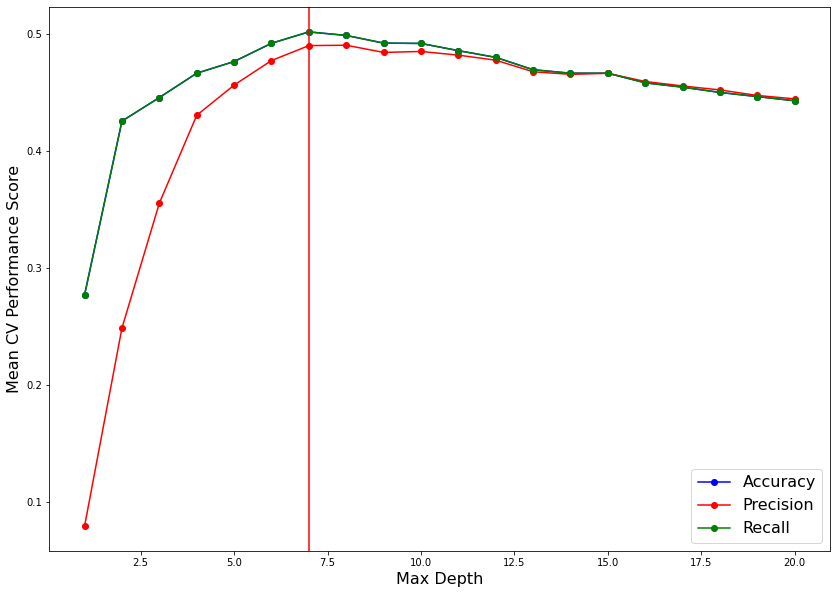

In [6]:
best_depth = np.argmax(np.mean(accs, axis=0))+1
plt.figure(figsize=(14,10))

plt.plot(range(1,n+1), np.mean(accs,axis=0),'b-o', label="Accuracy")
plt.plot(range(1,n+1), np.mean(precs,axis=0),'r-o', label="Precision")
plt.plot(range(1,n+1), np.mean(recs,axis=0),'g-o', label="Recall")
plt.axvline(x=best_depth, color='r')
#plt.annotate("best depth",(best_k+1,37.3), fontsize=14)
plt.ylabel("Mean CV Performance Score",fontsize=16)
plt.xlabel("Max Depth",fontsize=16)

plt.legend(fontsize=16)

plt.show()

In [7]:
print(f"The highest accuraccy is in the model with a max depth of {best_depth}.")

The highest accuraccy is in the model with a max depth of 7.


## CV for feature subset

In [8]:
feature_list = ['BlockDensity','OtherPuzAns','AvgAnswerLength','PctPerplex','PctOneWdHints','NumRepeatedAnswers_Norm', 'PctPNC','PctWP']
feature_combos = powerset(feature_list)


accs = np.zeros((5,len(feature_combos)))
precs = np.zeros((5,len(feature_combos)))
recs = np.zeros((5,len(feature_combos)))



for j, combo in enumerate(feature_combos):
    X = features[combo].to_numpy()
    y = features[['WeekdayNum']].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.25,
                                                        random_state = 440, 
                                                        shuffle=True,
                                                        stratify=y)

    kfold = StratifiedKFold(n_splits=5,shuffle = True,random_state=440)
    
    if j % 25 == 0:
        print(f"Iteration {j} of {len(feature_combos)}...")

    tree_clf = DecisionTreeClassifier(max_depth=8, random_state=440)

    i=0
    for train_index, test_index in kfold.split(X_train,y_train):
        X_train_train, X_train_test = X_train[train_index], X_train[test_index]
        y_train_train, y_train_test = y_train[train_index], y_train[test_index]

        tree_clone = clone(tree_clf)
        tree_clone.fit(X_train_train, y_train_train)

        y_pred = tree_clone.predict(X_train_test)
        accs[i,j] = accuracy_score(y_train_test,y_pred)
        precs[i,j] = precision_score(y_train_test,y_pred,average='weighted',zero_division=0)
        recs[i,j] = recall_score(y_train_test,y_pred,average='weighted',zero_division=0)
        i = i + 1

Iteration 0 of 255...
Iteration 25 of 255...
Iteration 50 of 255...
Iteration 75 of 255...
Iteration 100 of 255...
Iteration 125 of 255...
Iteration 150 of 255...
Iteration 175 of 255...
Iteration 200 of 255...
Iteration 225 of 255...
Iteration 250 of 255...


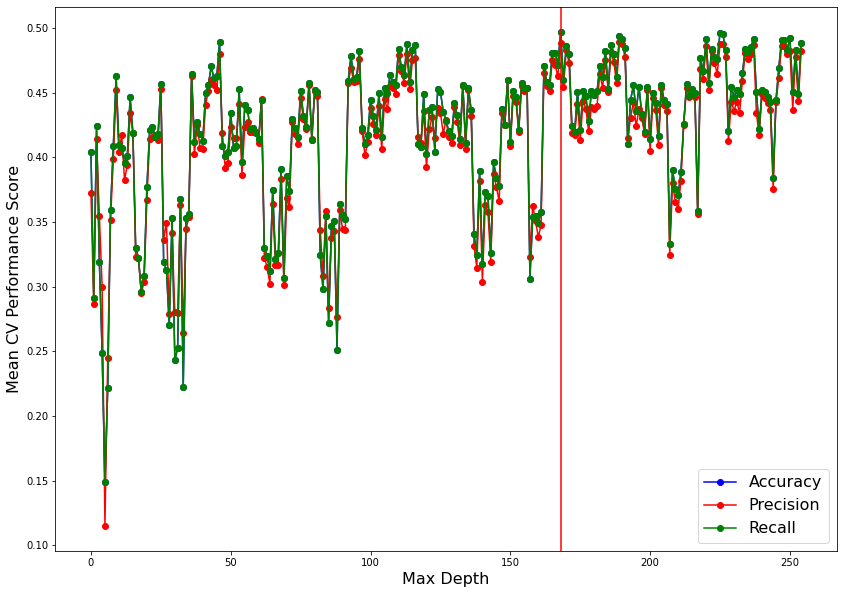

In [9]:
best_features = np.argmax(np.mean(accs, axis=0))
plt.figure(figsize=(14,10))

plt.plot(range(len(feature_combos)), np.mean(accs,axis=0),'b-o', label="Accuracy")
plt.plot(range(len(feature_combos)), np.mean(precs,axis=0),'r-o', label="Precision")
plt.plot(range(len(feature_combos)), np.mean(recs,axis=0),'g-o', label="Recall")
plt.axvline(x=best_features, color='r')
#plt.annotate("best depth",(best_k+1,37.3), fontsize=14)
plt.ylabel("Mean CV Performance Score",fontsize=16)
plt.xlabel("Max Depth",fontsize=16)

plt.legend(fontsize=16)

plt.show()

In [10]:
print(f"The highest accuraccy is in the model the features {feature_combos[best_features]}.")

The highest accuraccy is in the model the features ['BlockDensity', 'OtherPuzAns', 'AvgAnswerLength', 'PctOneWdHints', 'PctWP'].


## details on best model

In [11]:
X = features[feature_combos[best_features]].to_numpy()
y = features[['WeekdayNum']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 440, 
                                                    shuffle=True,
                                                    stratify=y)
tree_f = DecisionTreeClassifier(max_depth=9, random_state=440)
tree_f.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, random_state=440)

In [12]:
# # This code plots the tree, but it is both too tiny and too large
# plt.figure(figsize = (20,20))
# fig = tree_f.fit(X_test, y_test)
# tree.plot_tree(fig,filled = True,class_names=class_labels)
# plt.show()
# #plt.savefig("tree2.pdf")

In [13]:
y_pred = tree_f.predict(X_test)
f_acc = accuracy_score(y_test,y_pred)
f_prec = precision_score(y_test,y_pred,average='micro')
f_rec = recall_score(y_test,y_pred,average='micro')
print(f"Overall scores:")
print(f"Accuracy:\t{np.round(f_acc*100,2)}%")
print(f"Precision:\t{np.round(f_prec*100,2)}%")
print(f"Recall:\t\t{np.round(f_rec*100,2)}%")

Overall scores:
Accuracy:	49.39%
Precision:	49.39%
Recall:		49.39%


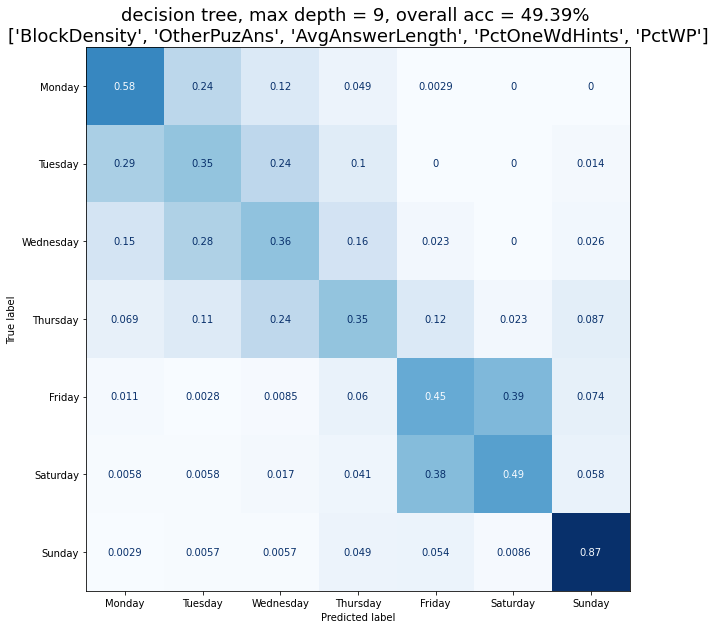

features: ['BlockDensity', 'OtherPuzAns', 'AvgAnswerLength', 'PctOneWdHints', 'PctWP']


In [14]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(tree_f, X_test, y_test, 
                      display_labels=class_labels,
                      ax=ax, 
                      normalize='true',
                      cmap=cm.get_cmap('Blues'),
                      colorbar=False)
ax.set_title(f"decision tree, max depth = 9, overall acc = {np.round(f_acc*100,2)}% \n{feature_combos[best_features]}", fontsize=18)
plt.savefig("dtree-results.png")
plt.show()
print("features:",feature_combos[best_features])